# **Drug sentiment Analysis**

## 1. Colab Setup

In [ ]:
# Install PySpark and Spark NLP
! pip install -q pyspark==3.1.2 spark-nlp

     |████████████████████████████████| 212.4 MB 61 kB/s 
     |████████████████████████████████| 643 kB 54.2 MB/s 
     |████████████████████████████████| 198 kB 69.9 MB/s 


In [ ]:
# Install library for finding Spark
!pip install -q findspark

In [ ]:
# import all required packages
from pyspark.sql.types import *
import datetime
from pyspark.sql.functions import *
from pyspark import SparkContext
from pyspark.sql import SQLContext
import pandas as pd

from google.colab import drive
drive.mount('/content/gdrive')

# Import findspark
import findspark

# To initialize PySpark
findspark.init()
#To verify the automatically detected location
findspark.find ()


Mounted at /content/gdrive


'/usr/local/lib/python3.7/dist-packages/pyspark'

In [ ]:
# Import SparkSession
from pyspark.sql import SparkSession
# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Check Spark Session Information
spark

In [ ]:
#spark = sparknlp.start()

In [ ]:
customschema = StructType([
StructField("UniqueID", DoubleType(), True)
,StructField("drugName", StringType(), True)
,StructField("condition", StringType(), True)
,StructField("review", StringType(), True)
,StructField("rating", StringType(), True)
,StructField("date", StringType(), True)
,StructField("usefulCount", StringType(), True)
])

df1 = spark.read.format("csv")\
           .option("delimiter", "\t")\
           .option("header", "true")\
           .option("quote", "\"")\
           .option("escape", "\"")\
           .option("multiLine","true")\
           .option("quoteMode","ALL")\
           .option("mode","PERMISSIVE")\
           .option("ignoreLeadingWhiteSpace","true")\
           .option("ignoreTrailingWhiteSpace","true")\
           .option("parserLib","UNIVOCITY")\
           .schema(customschema)\
           .load("gdrive/My Drive/Colab Notebooks/Dataset/drugsComTrain_raw.tsv")

In [ ]:
df1.show(5)

+--------+--------------------+--------------------+--------------------+------+-----------------+-----------+
|UniqueID|            drugName|           condition|              review|rating|             date|usefulCount|
+--------+--------------------+--------------------+--------------------+------+-----------------+-----------+
|206461.0|           Valsartan|Left Ventricular ...|"It has no side e...|   9.0|     May 20, 2012|         27|
| 95260.0|          Guanfacine|                ADHD|"My son is halfwa...|   8.0|   April 27, 2010|        192|
| 92703.0|              Lybrel|       Birth Control|"I used to take a...|   5.0|December 14, 2009|         17|
|138000.0|          Ortho Evra|       Birth Control|"This is my first...|   8.0| November 3, 2015|         10|
| 35696.0|Buprenorphine / n...|   Opiate Dependence|"Suboxone has com...|   9.0|November 27, 2016|         37|
+--------+--------------------+--------------------+--------------------+------+-----------------+-----------+
o

In [ ]:
pandas_df = df1.toPandas()
pandas_df['UniqueID'] = pd.to_numeric(pandas_df["UniqueID"])
pandas_df['rating'] = pd.to_numeric(pandas_df["rating"])
pandas_df['usefulCount'] = pd.to_numeric(pandas_df["usefulCount"])

In [ ]:
pandas_df.head()

,UniqueID,drugName,condition,review,rating,date,usefulCount
0,206461.0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260.0,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703.0,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000.0,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696.0,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
unique_stopwords = set(STOPWORDS)
import seaborn as sns

#### Most Common used DrugNames in Dataset

In [ ]:
class eda_class:

  def __init__(self, df):
    self.df = df
    
  def wordcloud(self, column, title):
    wc = WordCloud(background_color='black', stopwords=unique_stopwords, max_words=1000).generate(str(column))
    plt.figure(figsize=(14,10))
    plt.title(f'{title}', fontsize = 25)
    print(wc)
    plt.axis('off')
    plt.imshow(wc)
    plt.show()

  def rating_percent(self):
    pd.Series(self.df['rating'].value_counts()/self.df['rating'].size*100).plot(kind = "bar",figsize=(8,6),rot = 0, color='black')
    plt.title("Rating Percentage Distribution")
    plt.xlabel("Ratings")
    plt.ylabel("Percentage")
    plt.show()

  def top_conditions(self):
    cond = dict(self.df['condition'].value_counts())
    plt_ = sns.barplot(x = list(cond.keys())[0:5], y = list(cond.values())[0:5], palette = 'winter')
    plt_.set_title("Top 10 conditions")
    plt_.set_xlabel("Conditions")
    plt_.set_ylabel("Count")

  def top_bc_drugs(self):
    top_bc_drug = self.df[(self.df['condition']=='Birth Control') & (self.df['rating'] > 7.0) & (self.df['usefulCount'] >= 100)]
    pd.crosstab(top_bc_drug['drugName'],top_bc_drug['rating']).plot(kind='bar',figsize=(10, 6),alpha=0.5,rot=0,stacked=True,title="Top Birth Control Drugs")
    plt.xticks(rotation=90)
    plt.show()

  def top_depression_drugs(self):
    top_dep_drug = self.df[(self.df['condition']=='Depression') & (self.df['rating'] >= 9.0) & (self.df['usefulCount'] >= 100)]
    pd.crosstab(top_dep_drug['drugName'],top_dep_drug['rating']).plot(kind='bar',figsize=(15, 6),alpha=0.5,rot=0,stacked=True,title="Top top_dep_drug Drugs")
    plt.xticks(rotation=90)
    plt.show()

In [ ]:
eda_p = eda_class(pandas_df)

#### Wordcloud of DrugNames

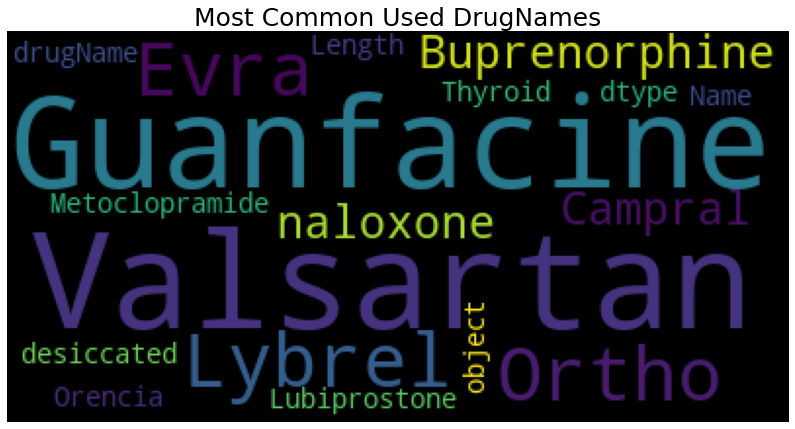

In [ ]:
eda_p.wordcloud(pandas_df['drugName'], 'Most Common Used DrugNames')

#### Ratings Percentage Distribution

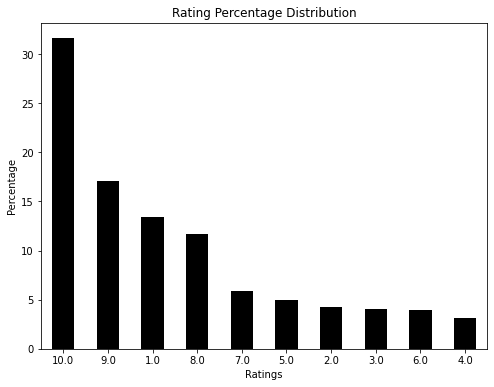

In [ ]:
eda_p.rating_percent()

#### Top 5 Conditions

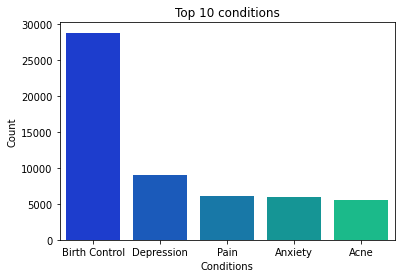

In [ ]:
eda_p.top_conditions()

#### Top Birth Control Drugs

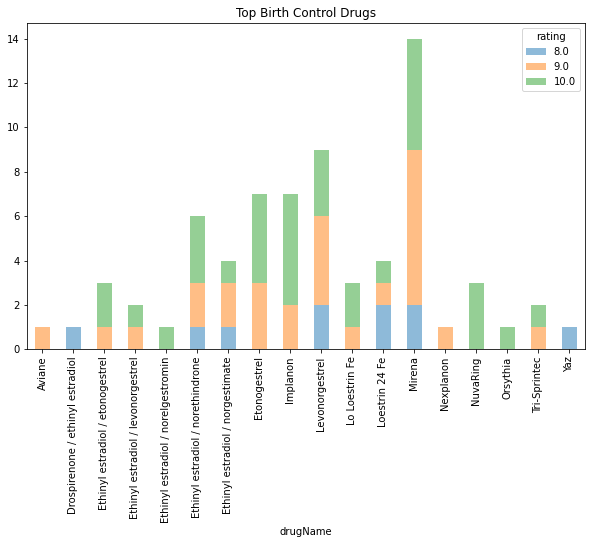

In [ ]:
eda_p.top_bc_drugs()

#### Top Depression Drugs

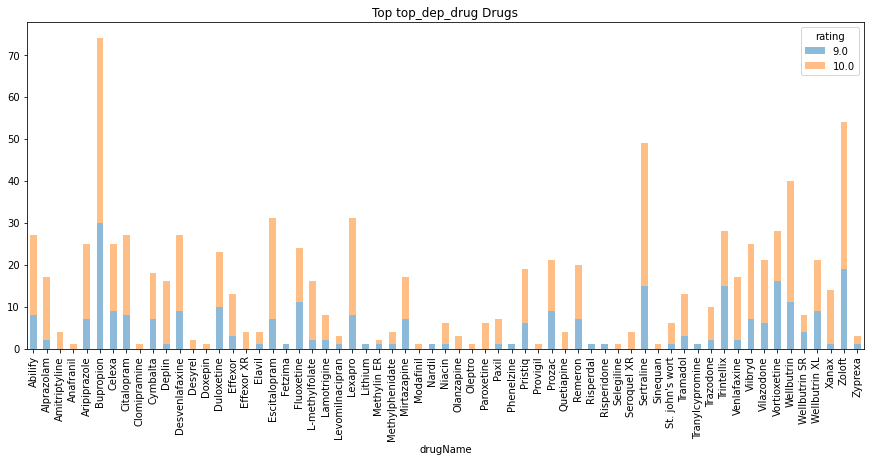

In [ ]:
eda_p.top_depression_drugs()

#### WordCloud of reviews

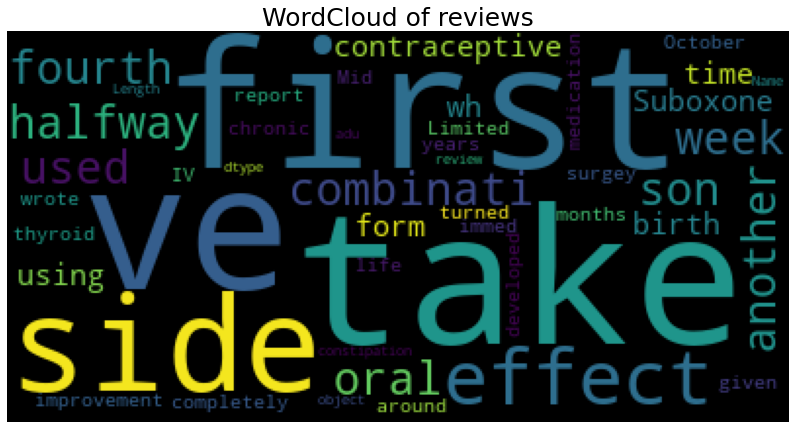

In [ ]:
eda_p.wordcloud(pandas_df['review'], 'WordCloud of reviews')

In [ ]:
pandas_df.loc[(pandas_df['rating'] >= 5), 'review_sent'] = 1
pandas_df.loc[(pandas_df['rating'] < 5), 'review_sent'] = 0

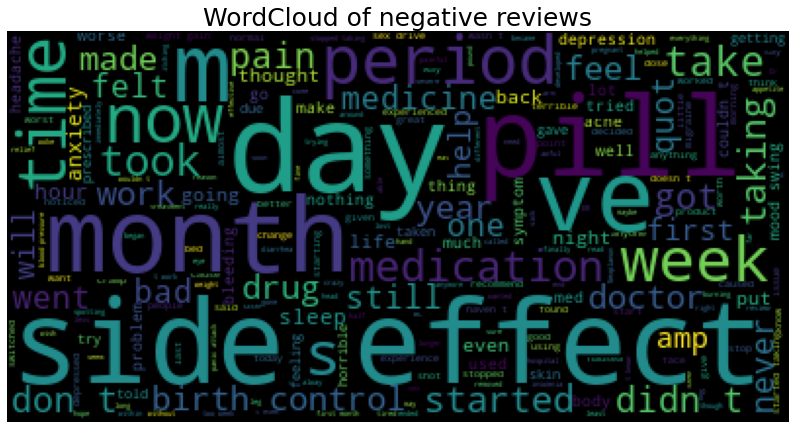

In [ ]:
negative_sentiments = " ".join([text for text in pandas_df['review'][pandas_df['review_sent'] == 0]])
eda_p.wordcloud(negative_sentiments, 'WordCloud of negative reviews')

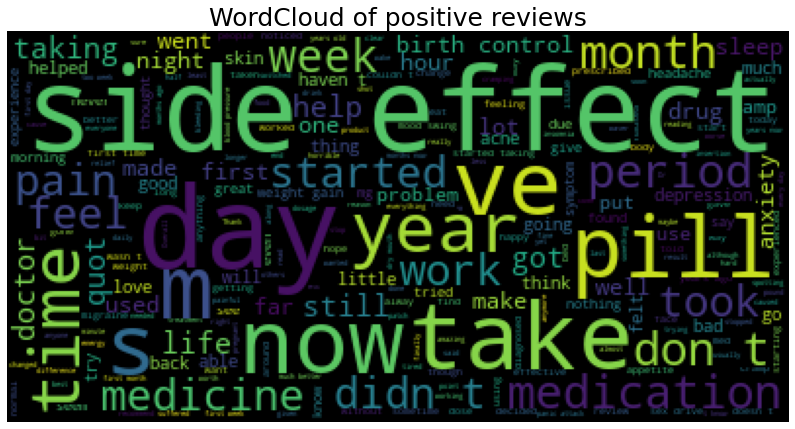

In [ ]:
positive_sentiments = " ".join([text for text in pandas_df['review'][pandas_df['review_sent'] == 1]])
eda_p.wordcloud(positive_sentiments, 'WordCloud of positive reviews')